<a href="https://colab.research.google.com/github/OliverWills/Cars/blob/main/BERT_cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import pandas as pd

In [ ]:
# Import required packages
import os
import time
import datetime
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertModel, BertForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup

In [ ]:
# Mount Google Drive and read data from CSV file
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/My Drive/BMW_cleansed.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data['id']=data['Link'].str.split('/').str[-1]
data['age']=datetime.datetime.now().year-data['Year']

In [ ]:
data['combined']=data['id']+\
  " This is "+data['Title']+\
  ". It is located in "+data['Location']+\
  ". The car is "+data['age'].astype(str)+\
  " years old. It has an engine size of "+data['Engine Size'].astype(str)+\
  "cc. It uses "+data['Fuel Type']+\
  " fuel. It has done "+data['Mileage'].astype(str)+\
  " miles. "+data['Description']

In [ ]:
# Drop missing values and extract descriptions
data=data.dropna()

In [ ]:
# Cut off Prices at greater than Q3 + 1.5 IQR
Q1, Q3 = data.Price.quantile([0.25,0.75])
IQR = Q3 - Q1
limit = Q3 + 1.5 * IQR
data=data[data['Price']<limit]

In [ ]:
data = data[['Price','combined']]
descriptions=data['combined'].tolist()

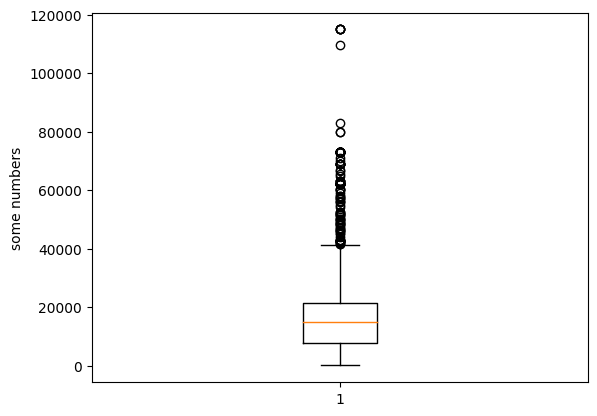

In [ ]:
plt.boxplot(data['Price'])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

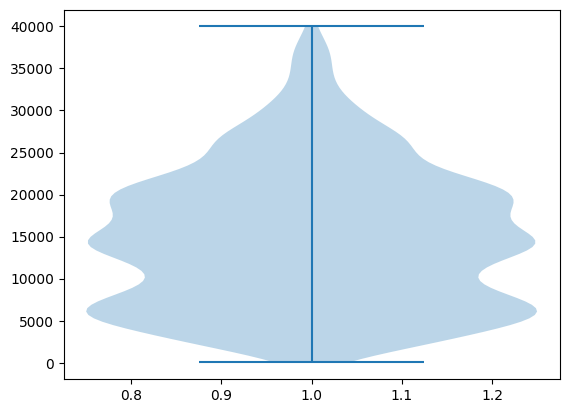

In [ ]:
plt.violinplot(data['Price'])
plt.show

In [ ]:
# Download and define tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# encode descriptions using tokenizer
encoded_corpus = tokenizer(text=descriptions,
  add_special_tokens=True,
  padding='max_length',
  truncation='longest_first',
  max_length=512,
  return_attention_mask=True)

In [ ]:
# Define input ids and attention masks
input_ids = encoded_corpus['input_ids']
attention_mask = encoded_corpus['attention_mask']

input_ids = np.array(input_ids)
attention_mask = np.array(attention_mask)
labels = data['Price'].to_numpy()

In [ ]:
# Split train and test inputs and labels
test_size = 0.1
seed = 42

train_valid_inputs, test_inputs, train_valid_labels, test_labels = \
            train_test_split(input_ids, labels, test_size=test_size,
                             random_state=seed)

train_inputs, valid_inputs, train_labels, valid_labels = \
            train_test_split(train_valid_inputs, train_valid_labels, test_size=test_size,
                             random_state=seed)

train_valid_masks, test_masks, _, _ = train_test_split(attention_mask,
                                        labels, test_size=test_size,
                                        random_state=seed)

train_masks, valid_masks, _, _ = train_test_split(train_valid_masks,
                                        train_valid_labels, test_size=test_size,
                                        random_state=seed)

In [ ]:
# Scale labels (prices)
price_scaler = StandardScaler()
price_scaler.fit(train_labels.reshape(-1, 1))

train_labels = price_scaler.transform(train_labels.reshape(-1, 1))
valid_labels = price_scaler.transform(valid_labels.reshape(-1, 1))

In [ ]:
# Define and create train and test dataloaders
batch_size = 16
def create_dataloaders(inputs, masks, labels, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, mask_tensor,
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            shuffle=True)
    return dataloader

In [ ]:
train_dataloader = create_dataloaders(train_inputs, train_masks,
                                      train_labels, batch_size)
test_dataloader = create_dataloaders(test_inputs, test_masks,
                                     test_labels, batch_size)
valid_dataloader = create_dataloaders(valid_inputs, valid_masks,
                                     valid_labels, batch_size)

In [ ]:
# The PyTorch code to implement this model is actually quite straightforward.
# Our CamembertRegressor is a PyTorch nn.Module with two new attributes:
    # an instance of the pretrained CamembertModel from the transformers library,
    # a single layer regression network taking as input a 768 long input and giving a single output value
# The forward method passes the tokenized input trough the CamembertModel and collects the 768 long vector corresponding
# to the “Class Label” output token. It then passes that vector through the regression layer that outputs the predicted value.

class BertRegressor(nn.Module):

    def __init__(self, drop_rate=0.2, freeze_bert=False):

        super(BertRegressor, self).__init__()
        D_in, D_out = 768, 1

        self.bert = \
                   BertModel.from_pretrained('bert-base-cased')
        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(D_in, D_out))
    def forward(self, input_ids, attention_masks):

        outputs = self.bert(input_ids, attention_masks)
        class_label_output = outputs[1]
        outputs = self.regressor(class_label_output)
        return outputs

model = BertRegressor(drop_rate=0.2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
# Define the optimizer and the learning rate scheduler for our training process.
# We will use the Adam optimizer with a 5e-5 learning rate as was done in the official BERT paper.
optimizer = torch.optim.AdamW(model.parameters(),
                  lr=5e-5,
                  eps=1e-8)

# To define our scheduler, we must calculate the total number of training steps which is simply
# the number of training observations multiplied by the number of epochs.
# We will fine tune our model on 5 epochs.
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                 num_warmup_steps=0, num_training_steps=total_steps)

# Loss function will be the Mean Squared Error loss, the most common loss function for regression problems.
loss_function = nn.MSELoss()

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def evaluate(model, loss_function, test_dataloader, device):
    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()
    # Tracking variables
    test_loss, test_r2 = [], []
    # Unpack this training batch from our dataloader.
    for batch in test_dataloader:
        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
        batch_inputs, batch_masks, batch_labels = \
                                 tuple(b.to(device) for b in batch)
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            outputs = model(batch_inputs, batch_masks)
        loss = loss_function(outputs, batch_labels)
        test_loss.append(loss.item())
        r2 = r2_score(outputs, batch_labels)
        test_r2.append(r2.item())
    return test_loss, test_r2

def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [ ]:
def train(model, optimizer, scheduler, loss_function, epochs,
          train_dataloader, device, clip_value=2):

    # We'll store a number of quantities such as training and validation loss,
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    for epoch in range(epochs):
        # Perform one full pass over the training set.
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
        print('Training...')
        # Measure how long the training epoch takes
        t0 = time.time()
        # Reset the total loss for this epoch.
        total_train_loss = 0
        best_loss = 1e10
        model.train()
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 10 == 0 and not step == 0:
              elapsed = format_time(time.time() - t0)
              print(' Batch {:>5,} of {:>5,}. Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            batch_inputs, batch_masks, batch_labels = \
                               tuple(b.to(device) for b in batch)
            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)

            loss = loss_function(outputs.squeeze(),
                             batch_labels.squeeze().float())
            total_train_loss += loss.item()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))
        print("")
        print("Running Validation...")

        t0 = time.time()

        # Evaluate data for one epoch
        valid_loss, valid_r2 = evaluate(model, loss_function, valid_dataloader, device)

        # Accumulate the validation loss.
        total_eval_loss = sum(valid_loss)

        # Report the final R2 for this validation run.
        avg_r2 = sum(valid_r2) / len(valid_dataloader)
        print("  Average R_squared: {:}".format(avg_r2))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(valid_dataloader)
        print("  Average Validation Loss: {0:.2f}".format(avg_val_loss))

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_r2,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")
    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

    return model

In [ ]:
# Helper function for formatting elapsed times as hh:mm:ss
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
model = train(model, optimizer, scheduler, loss_function, epochs,
              train_dataloader, device, clip_value=2)

In [ ]:
def predict(model, dataloader, device):
    model.eval()
    output = []
    for batch in dataloader:
        batch_inputs, batch_masks, _ = \
                                  tuple(b.to(device) for b in batch)
        with torch.no_grad():
            output += model(batch_inputs,
                            batch_masks).view(1,-1).tolist()[0]
    return output

In [ ]:
y_pred_scaled = predict(model, test_dataloader, device)

In [ ]:
input_text = [descriptions[0],descriptions[1]]
label = [[data['Price'][0],data['Price'][1]]]

encoded_text = tokenizer(text=input_text,
  add_special_tokens=True,
  padding='max_length',
  truncation='longest_first',
  max_length=512,
  return_attention_mask=True)

input_id = torch.Tensor(encoded_text['input_ids']).to(device).long()

input_attention_mask = torch.Tensor(encoded_text['attention_mask']).to(device).long()

print(input_id.size)
print(input_attention_mask.size)

model.eval()
with torch.no_grad():
    output = model(input_id, input_attention_mask).to('cpu').numpy()

pred_scaled = predict(model, input_dataloader, device)

y_pred = price_scaler.inverse_transform(output.reshape(-1, 1))

print(y_pred)
print(data['Price'][0])

<built-in method size of Tensor object at 0x7f275804e590>
<built-in method size of Tensor object at 0x7f27581d61d0>
[[ 7985.7344]
 [12181.645 ]]
7699.0


In [ ]:
print(label)

[[7699.0, 10999.0]]


In [ ]:
print(input_text)

['This is 2012 BMW 3 SERIES 328I M SPORT, full history, new timing chain. It is located in High Lane, Manchester. The car is 11 years old. It has an engine size of 1997cc. It uses Petrol fuel. It has done 129000 miles. 2012 BMW 238i M Sport , 129,659 Miles , Petrol , Cam belt 2019 - 88,299 miles , Timing chain July 2022, 1 month warranty included , 6 months warranty available, 6 speed gearbox , Full service history , 2 keys, Isofix , Book pack , Automatic LED ligh', 'This is bmw 125i sport plus edition 2dr step auto coupe m sport auto petrol. It is located in Cuffley, Hertfordshire. The car is 10 years old. It has an engine size of 2996cc. It uses Petrol fuel. It has done 76000 miles. SERIOUS ENQUIRIES ONLY PLEASE click sellers other items for more stock ULEZ COMPLIANT 6M Warranty BHP AUTOS Are Pleased To Offer This Stunning Modified Well Optioned BMW 125i SPORT PLUS EDITION Coupe Auto Presented In Metallic TITAN Silver with a Be']


In [ ]:
y_test = np.array(test_labels)
y_pred_scaled = np.array(y_pred_scaled)

y_pred = price_scaler.inverse_transform(y_pred_scaled.reshape(-1,1))

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
# mdape = ((pd.Series(y_test) - pd.Series(y_pred.reshape(-1,1)))\
        # / pd.Series(y_test)).abs().median()
r_squared = r2_score(y_test, y_pred)

In [ ]:
print(mae)
print(mdae)
print(mse)
print(mape)
print(r_squared)

9323.846594167953
7277.694256395194
140514056.36165658
1.0187853845292307
-0.9320779679929552


In [ ]:
import matplotlib.pyplot as plt

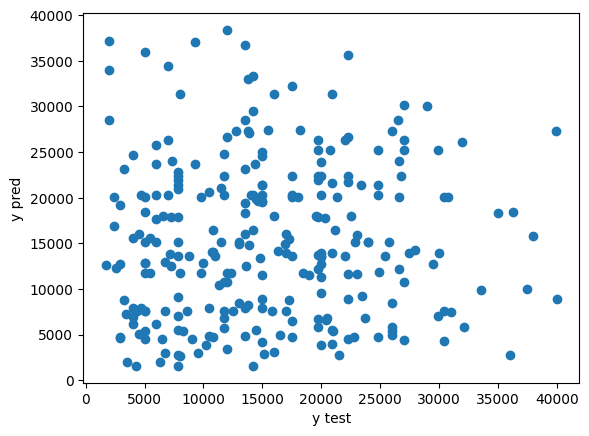

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel('y test')
plt.ylabel('y pred')
plt.show()

In [ ]:
results_df = pd.DataFrame(y_pred, columns=['y_pred'])
results_df['y_test']=pd.Series(y_test)
results_df['price_diff']=results_df['y_pred']-results_df['y_test']
results_df.sort_values('price_diff', axis=0, ascending=False, inplace=True)
print(results_df.head(10))

           y_pred   y_test    price_diff
159  37176.208229   2000.0  35176.208229
77   33983.957235   2000.0  31983.957235
48   35923.717277   5000.0  30923.717277
258  37071.692626   9300.0  27771.692626
14   34413.070378   6950.0  27463.070378
140  28496.857236   2000.0  26496.857236
120  38370.279658  12000.0  26370.279658
189  31347.333039   7990.0  23357.333039
52   36687.687221  13500.0  23187.687221
65   24668.758742   3981.0  20687.758742


In [ ]:
data[data['Price']==6950]['combined']

385     This is 2009 BMW X1 2.0 XDRIVE23D SE 5d 201 BH...
1185    This is BMW, Z3, Convertible, 2000, Manual, 27...
Name: combined, dtype: object

In [ ]:
print(data['combined'].loc[data.index[385]])

This is 2021 BMW Z4 sDrive 30i M Sport 2dr Auto Convertible Petrol Automatic. It is located in Bolton, Manchester. The car is 2 years old. It has an engine size of 1998cc. It uses Petrol fuel. It has done 15989 miles. This BMW Z4 2.0 30i M Sport Auto sDrive is a car that offers the ultimate in luxury and performance. It is equipped with a powerful 2.0-liter turbocharged engine, producing 255 horsepower and 295 lb-ft of torque, allowing for an exhilarating driving


In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


AttributeError: ignored

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(...)
tokenizer.save_pretrained('results/tokenizer/')

OSError: ignored

In [ ]:
output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

tokenizer.save_pretrained(output_dir)

('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json',
 './model_save/tokenizer.json')

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.save_pretrained('results/tokenizer/')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
torch.save(model.state_dict(), model)

AttributeError: ignored

In [ ]:
output_dir = 'results/tokenizer/'
tokenizer.from_pretrained(output_dir)

HFValidationError: ignored

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

NameError: ignored

In [ ]:
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/My Drive/BMW_cleansed.csv")

In [ ]:
path = f"/content/drive/My Drive/BERT_cars"

In [ ]:
#Save
torch.save(model.state_dict(), path)

In [ ]:
#Load
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()

In [ ]:
#Save/Load Entire Model
torch.save(model, path)

In [ ]:
path = f'content/gdrive/My Drive/Machine Learning Models/kaggle_jigsaw_{model_name}_iter_{iter}.pth'